<a href="https://colab.research.google.com/github/fvicencioh/FEM/blob/main/Tarea_2_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [168]:
# Definición de funciones utilizadas durante la tarea: Solución analítica, solución numérica y solución aproximada por funciones continuas.

def u_analitycal(x):
  C1 = 2.0
  C2 = (2*np.sin(1)-1)/(np.cos(1))
  u = C1*np.cos(x) + C2*np.sin(x) + x**2 - 2
  return u

def du_analitycal(x):
  C1 = 2.0
  C2 = (-1+2*np.sin(1))/(np.cos(1))
  du = -1*C1*np.sin(x) + C2*np.cos(x) + 2*x
  return du

def u_numerical(n,x):
  h = 1 / (n-1) # Elementos de igual ancho
  K = np.zeros((n, n)) # Matriz K global
  M = np.zeros((n, n)) # Matriz M global
  F = np.zeros(n) # Vector de fuerzas externas global
  L = np.zeros((2,n)) # Matriz de compatibilidad

  K_e = (1/h) * np.array([[1., -1.],[-1. , 1]]) # Matriz K del elemento, constante.
  M_e = h * np.array([[1/3, 1/6],[1/6, 1/3]]) # Matriz M del elemento, constante.
  F_e = np.zeros(2) # Vector de fuerzas externas del elemento, variable.

  for i in range(n-1): # Ensamblaje de matrices globales
    L[0,i] = 1.0
    L[1,i+1] = 1.0

    K_a = np.matmul(np.matmul(np.transpose(L),K_e),L)
    K = K + K_a

    M_a = np.matmul(np.matmul(np.transpose(L),M_e),L)
    M = M + M_a

    F_e[0] = -(h/12)*(6*x[i]**2 + 4*h*x[i] + h**2)
    F_e[1] = -(h/12)*(6*x[i]**2 + 8*h*x[i] + 3*h**2)

    F_a = np.matmul(np.transpose(L),F_e)

    F = F + F_a

    L = np.zeros((2,n))

  # Ensamblaje de sistema lineal

  A = K - M # Matriz de coeficientes de u

  # Aplicación de condiciones de borde

  A[0,:] = 0 # Condición u(0) = 0
  A[:,0] = 0
  A[0,0] = 1
  F[0] = 0

  F[-1] = F[-1] + 1 # Condición du/dx|1 = 1

  u_num = np.matmul(np.linalg.inv(A),F)
  du_num = np.diff(u_num) / h
  return u_num, du_num

def petrov_galerkin(n,x):
  K = np.zeros((n,n), dtype=float)
  F = np.zeros(n, dtype=float)
  u_j = np.zeros(len(x))
  du_j = np.zeros (len(x))
  for i in range(n):
    m_i = (i+0.5)*np.pi # Para ser consistente con i partiendo desde 0.
    for j in range(n):
      K[i,j] = quad(integrand, 0, 1, args=(i,j+1))[0]
    F[i] = quad(external_forces, 0, 1, args=(i))[0]
    F[i]+= -np.sin(m_i)
  alpha = np.linalg.solve(K,F)
  for j in range(n):
    u_j+= x**(j+1) * alpha[j] # Cálculo de u en el dominio
    du_j+= (j+1)*x**(j) * alpha[j] #Cálculo de la derivada de u en el dominio
  return u_j, du_j

def integrand(x, i, j):
  m_i = (i + 0.5)*np.pi
  return (x**j * np.sin(m_i*x))-(j*m_i*np.cos(m_i*x)*x**(j-1))

def external_forces(x,i):
  m_i = (i + 0.5)*np.pi
  return np.sin(m_i*x)*x**2

def minimum_squares(n,x):
  K = np.zeros((n,n), dtype=float)
  M = np.zeros((n,n), dtype=float)
  F = np.zeros(n, dtype=float)
  u_j = np.zeros(len(x))
  for i in range(n):
    m_i = (i+0.5)*np.pi
    for j in range(n):
      m_j = (j+0.5)*np.pi
      K[i,j] = quad(K_ms, 0, 1, args=(i,j))[0]
      M[i,j] = quad(M_ms, 0, 1, args=(i,j))[0]
    F[i] = quad(external_forces_ms, 0, 1, args=(i))[0]
    F[i]+= -(-(m_i**2)*np.sin(m_i) + np.sin(m_i)) # (ddphi(1) + phi(1))*Q_L

  alpha = np.linalg.solve((K-M),F)

  u_j+= x # Se agrega la solución particular
  du_j = np.ones(len(x)) # Se agrega la derivada de la solución particular

  for j in range(n):
    m_j = (j+0.5)*np.pi
    u_j+=alpha[j]*np.sin(m_j*x)
    du_j+= alpha[j]*m_j*np.cos(m_j*x)
  return u_j, du_j

def K_ms(x,i,j):
  # Función de Forma phi_j = sin(m_j x)

  m_i = (i+0.5)*np.pi
  m_j = (j+0.5)*np.pi

  phi_i = np.sin(m_i*x)
  phi_j = np.sin(m_j*x)

  ddphi_i = -(m_i**2)*np.sin(m_i*x)

  return phi_j*(ddphi_i+phi_i)

def M_ms(x,i,j):
  # Función de Forma phi_j = sin(m_j x)

  m_i = (i+0.5)*np.pi
  m_j = (j+0.5)*np.pi

  dphi_i = m_i * np.cos(m_i*x)
  dphi_j = m_j * np.cos(m_j*x)

  dddphi_i = -(m_i**3)*np.cos(m_i*x)

  return dphi_j*(dddphi_i + dphi_i)

def external_forces_ms(x,i):

  m_i = (i+0.5)*np.pi

  phi = np.sin(m_i*x)
  dphi_i = m_i * np.cos(m_i*x)
  ddphi = -(m_i**2)*np.sin(m_i*x)
  dddphi_i = -(m_i**3)*np.cos(m_i*x)

  return (x**2 - x)*(ddphi + phi) + (dddphi_i + dphi_i)



## Cálculo de solución analítica en todo el dominio

In [ ]:
# Calcula la solución analítica y la guarda para posteriores gráficos

x_a = np.linspace(0,1,1000)
sol_analitycal = u_analitycal(x_a)
du_a = du_analitycal(x_a)

## Aproximación numérica mediante el método de Galerkin

### Comparación Numérica vs Analítica

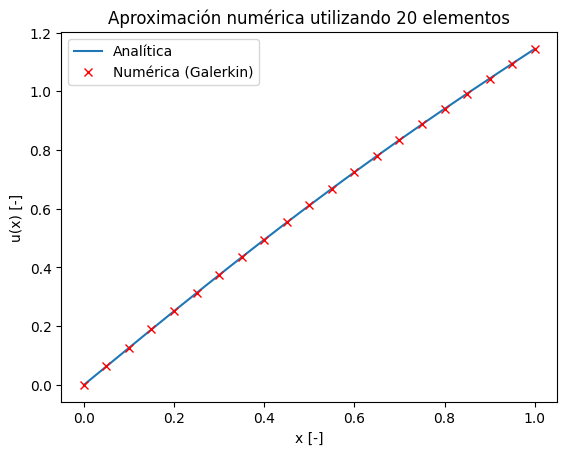

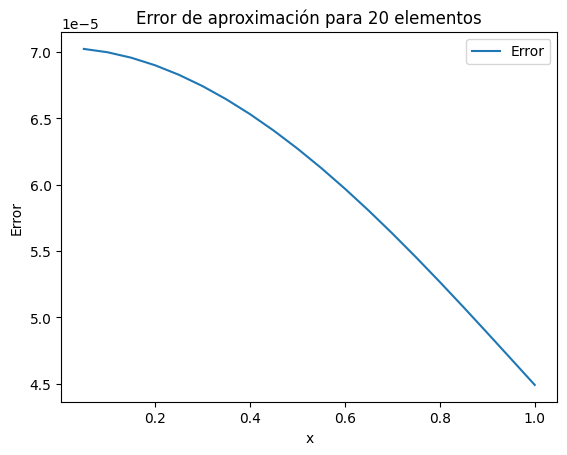

In [ ]:
e = 20 # Número de elementos
n = e+1 # Número de nodos
h = 1 / e # Ancho de cada elemento

sol_analitycal_e = np.zeros(n)
sol_numerical = np.zeros(n)

x_n = np.linspace(0,1,n)

error = np.zeros(n)

sol_analitycal_e = u_analitycal(x_n)
sol_numerical,_ = u_numerical(n, x_n)

for i in range(n):
  if i>0:
    error[i] = np.abs(sol_analitycal_e[i] - sol_numerical[i])/np.abs(sol_analitycal_e[i])

fig, ax = plt.subplots()
ax.plot(x_a, sol_analitycal, label ='Analítica', linestyle="-")
ax.plot(x_n, sol_numerical, label ='Numérica (Galerkin)', marker='x', linestyle="None",color='red')
ax.set_xlabel('x [-]')
ax.set_ylabel('u(x) [-]')
ax.set_title(f'Aproximación numérica utilizando {e} elementos')

ax.legend()

fig_2, error_plot = plt.subplots()
error_plot.plot(x_n[1:], error[1:], label ='Error')
error_plot.set_xlabel('x')
error_plot.set_ylabel('Error')
error_plot.legend()
error_plot.set_title(f'Error de aproximación para {e} elementos')

plt.show()

### Cálculo de error y tasa de convergencia - Galerkin

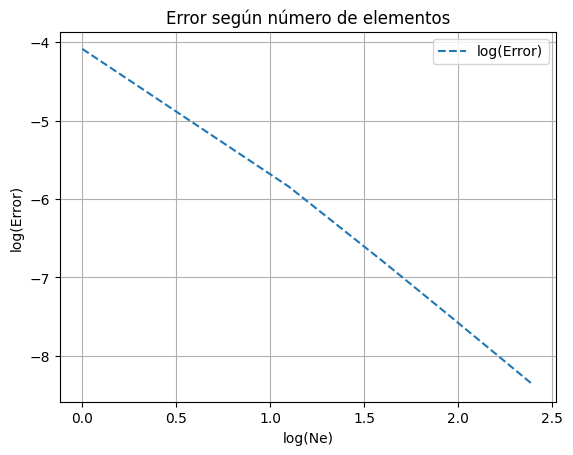

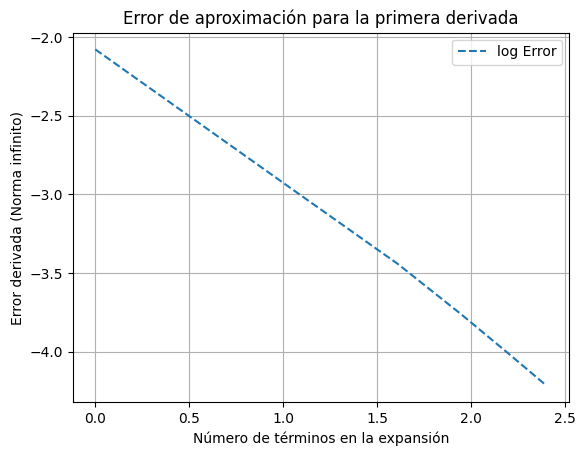

In [206]:
reps = 6
error_max_u_g = np.zeros(reps)
error_max_du_g = np.zeros(reps)
elements = np.zeros(reps)
for i in range(reps):
  e = 1 + i*2 # Número de elementos en cada iteración
  n = e + 1 # Número de nodos en cada iteración
  h = 1/e # Ancho del elemento en cada iteración.
  error_rep_u = np.zeros(n) # Arreglo que almacena el error solo en esta repetición
  error_rep_du = np.zeros(n)
  x_n = np.linspace(0,1,n)
  sol_analitycal_e = u_analitycal(x_n) # Almacena la solución analítica solo en los puntos donde se calcula la numérica.
  du_a_e = du_analitycal(x_n) # Almacena la derivada analítica solo en los puntos donde se calcula la numérica.
  sol_numerical,dummy = u_numerical(n, x_n) # Almacena la solución numérica.
  du_numerical = np.append(dummy,dummy[-1])
  error_rep_u[1:] = np.abs((sol_analitycal_e[1:] - sol_numerical[1:])/(sol_analitycal_e[1:]))
  error_max_u_g[i] = np.max(error_rep_u)
  error_rep_du[1:] = np.abs((du_a_e[1:]-du_numerical[1:])/(du_a_e[1:]))
  error_max_du_g[i] = np.max(error_rep_du)
  elements[i] = e

fig, ax = plt.subplots()
ax.plot(np.log(elements), np.log(error_max_u_g), label ='log(Error)', linestyle="--")
ax.set_xlabel('log(Ne)')
ax.set_ylabel('log(Error)')
ax.set_title('Error según número de elementos')
plt.grid(True)
ax.legend()

fig, ax2 = plt.subplots()
ax2.plot(np.log(elements), np.log(error_max_du_g), label ='log Error', linestyle="--")
ax2.set_xlabel('Número de términos en la expansión')
ax2.set_ylabel('Error derivada (Norma infinito)')
ax2.set_title('Error de aproximación para la primera derivada')
plt.grid(True)
ax2.legend()

### Análisis de la derivada

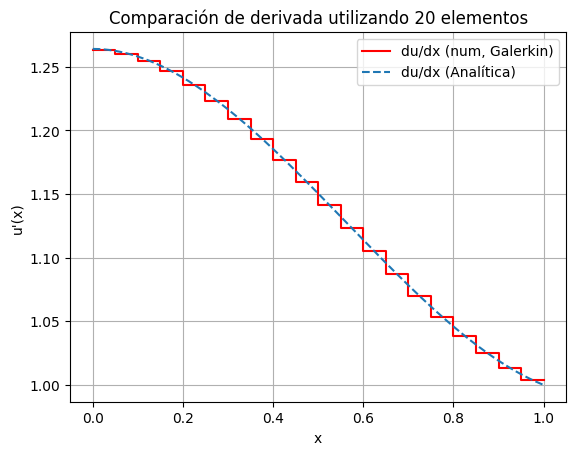

In [166]:
n = 21
x_n = np.linspace(0,1,n)
_,dummy = u_numerical(n,x_n)
du_num = np.append(dummy,dummy[-1])

plt.step(x_n, du_num, where='post', label="du/dx (num, Galerkin)",color='red')
plt.plot(x_a, du_a, '--', label='du/dx (Analítica)')
plt.xlabel("x"); plt.ylabel("u'(x)")
plt.legend(); plt.grid(True)
plt.title(f"Comparación de derivada utilizando {n-1} elementos")
plt.show()

## Aproximación mediante funciones continuas utilizando el método de Petrov-Galerkin

### Comparación Petrov-Galerkin vs solución Analítica

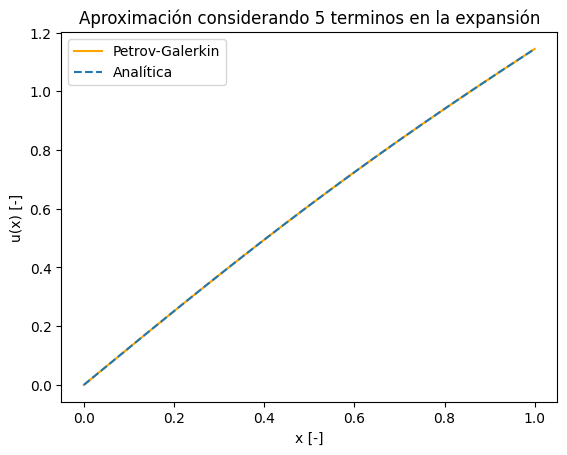

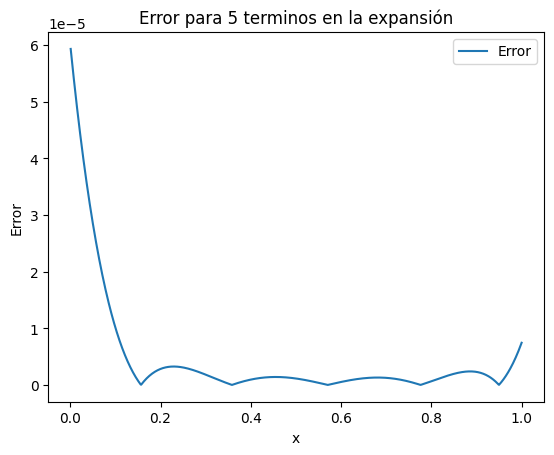

In [172]:
n = 5 # Número de términos en la expansión polinomial
x = np.linspace(0,1,1000)

sol_pg = np.zeros(len(x))

error = np.zeros(len(x))

sol_analitycal_e = u_analitycal(x)
sol_pg, _ = petrov_galerkin(n, x)

error[1:] = np.abs(sol_analitycal_e[1:] - sol_pg[1:])/np.abs(sol_analitycal_e[1:])

fig, ax = plt.subplots()
ax.plot(x, sol_pg, label ='Petrov-Galerkin', linestyle="-",color='orange')
ax.plot(x_a, sol_analitycal, label ='Analítica',linestyle='--')
ax.set_xlabel('x [-]')
ax.set_ylabel('u(x) [-]')
ax.set_title(f'Aproximación considerando {n} terminos en la expansión')
ax.legend()

fig_2, error_plot = plt.subplots()
error_plot.plot(x[1:], error[1:], label ='Error')
error_plot.set_xlabel('x')
error_plot.set_ylabel('Error')
error_plot.set_title(f'Error para {n} terminos en la expansión')
error_plot.legend()

plt.show()

### Análisis de error y tasa de convergencia

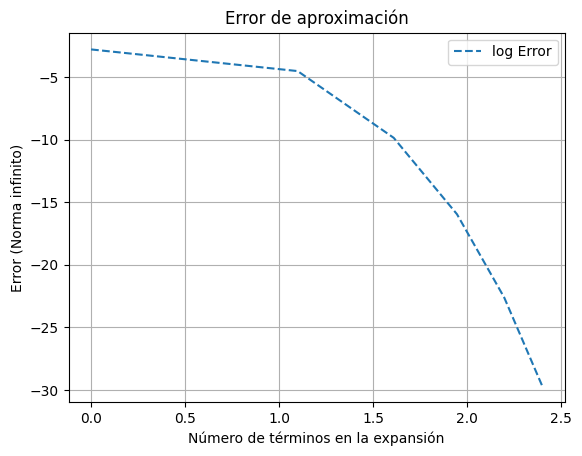

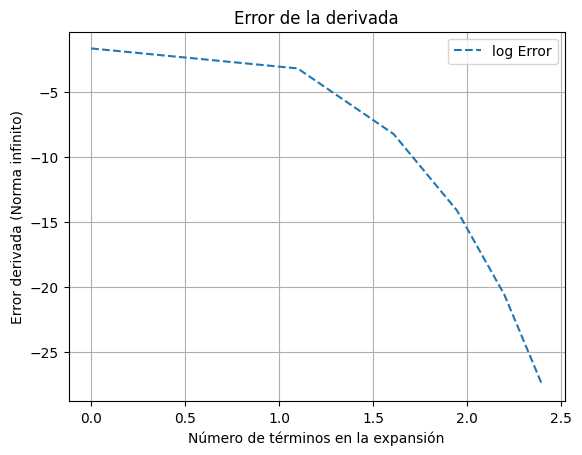

In [207]:
reps = 6
error_max_u_pg = np.zeros(reps)
error_max_du_pg = np.zeros(reps)
terms = np.zeros(reps)
for i in range(reps):
  n = 1 + 2*i
  error_rep_u = np.zeros(100) # Arreglo que almacena el error solo en esta repetición
  error_rep_du = np.zeros(100) # Arreglo que almacena el error para la derivada.
  x = np.linspace(0,1,100)
  sol_analitycal_e = u_analitycal(x) # Almacena la solución analítica solo en los puntos donde se calcula la numérica.
  du_a_e = du_analitycal(x) # Almacena la derivada analítica solo en los puntos donde se calcula la numérica.
  sol_pg, du_pg = petrov_galerkin(n, x) # Almacena la solución de Petrov Galerkin y su derivada.
  error_rep_u[1:] = np.abs((sol_analitycal_e[1:] - sol_pg[1:])/(sol_analitycal_e[1:]))
  error_max_u_pg[i] = np.max(error_rep_u)
  error_rep_du[1:] = np.abs((du_a_e[1:]-du_pg[1:])/(du_a_e[1:]))
  error_max_du_pg[i] = np.max(error_rep_du)
  terms[i] = n

fig, ax = plt.subplots()
ax.plot(np.log(terms), np.log(error_max_u_pg), label ='log Error', linestyle="--")
ax.set_xlabel('Número de términos en la expansión')
ax.set_ylabel('Error (Norma infinito)')
ax.set_title('Error de aproximación')
plt.grid(True)
ax.legend()

fig, ax2 = plt.subplots()
ax2.plot(np.log(terms), np.log(error_max_du_pg), label ='log Error', linestyle="--")
ax2.set_xlabel('Número de términos en la expansión')
ax2.set_ylabel('Error derivada (Norma infinito)')
ax2.set_title('Error de la derivada')
plt.grid(True)
ax2.legend()

### Análisis de la derivada Petrov-Galerkin vs Analítica

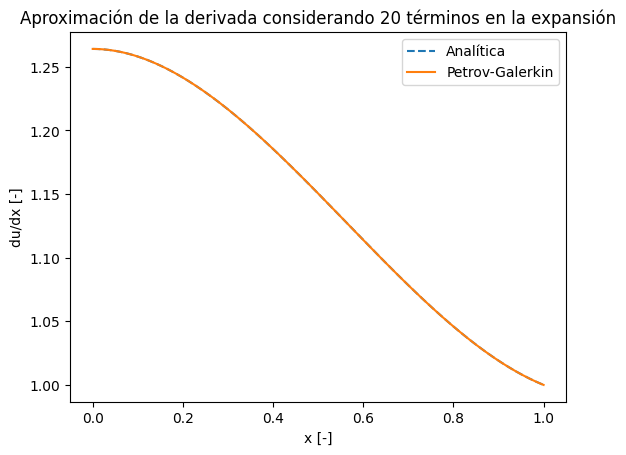

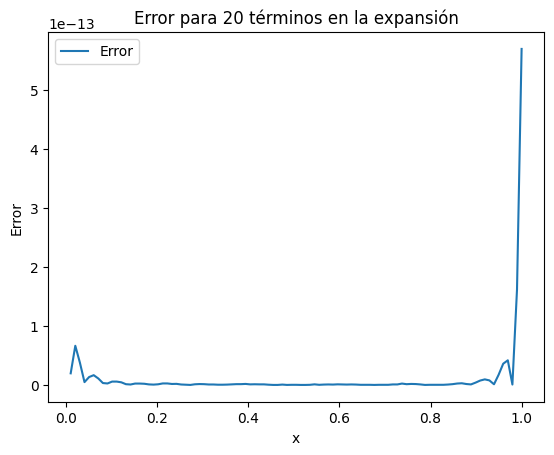

In [201]:
n = 20
x = np.linspace(0,1,100)
error = np.zeros(100)
du_a_e = du_analitycal(x)
_,du_pg = petrov_galerkin(n, x)
error[1:] = np.abs((du_a_e[1:] - du_pg[1:])/(du_a_e[1:]))

fig, ax = plt.subplots()
ax.plot(x_a, du_a, label ='Analítica',linestyle='--')
ax.plot(x, du_pg, label ='Petrov-Galerkin', linestyle="-")
ax.set_xlabel('x [-]')
ax.set_ylabel('du/dx [-]')
ax.set_title(f'Aproximación de la derivada considerando {n} términos en la expansión')
ax.legend()

fig_2, error_plot = plt.subplots()
error_plot.plot(x[1:], error[1:], label ='Error')
error_plot.set_xlabel('x')
error_plot.set_ylabel('Error')
error_plot.set_title(f'Error para {n} términos en la expansión')
error_plot.legend()

plt.show()

## Aproximación mediante funciones continuas utilizando Mínimos Cuadrados

### Comparación Mínimos Cuadrados vs solución analítica

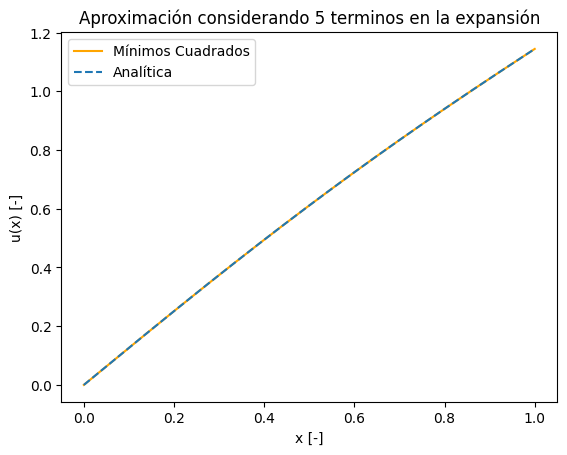

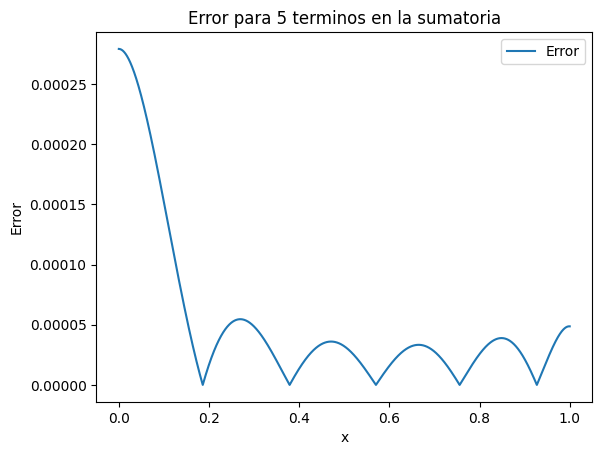

In [151]:
n = 5 # Número de términos en la expansión polinomial, no puede ser menor a 2
x = np.linspace(0,1,10000)

sol_ms = np.zeros(len(x))

error = np.zeros(len(x))

sol_analitycal_e = u_analitycal(x)
sol_ms,_= minimum_squares(n, x)

error[1:] = np.abs(sol_analitycal_e[1:] - sol_ms[1:])/np.abs(sol_analitycal_e[1:])

fig, ax = plt.subplots()
ax.plot(x, sol_ms, label ='Mínimos Cuadrados', linestyle="-",color='orange')
ax.plot(x_a, sol_analitycal, label ='Analítica',linestyle='--')
ax.set_xlabel('x [-]')
ax.set_ylabel('u(x) [-]')
ax.set_title(f'Aproximación considerando {n} terminos en la expansión')
ax.legend()

fig_2, error_plot = plt.subplots()
error_plot.plot(x[1:], error[1:], label ='Error')
error_plot.set_xlabel('x')
error_plot.set_ylabel('Error')
error_plot.set_title(f'Error para {n} terminos en la sumatoria')
error_plot.legend()

plt.show()

### Analisis de convergencia

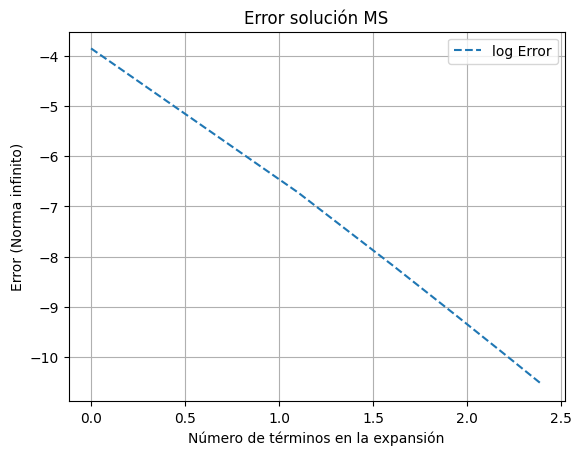

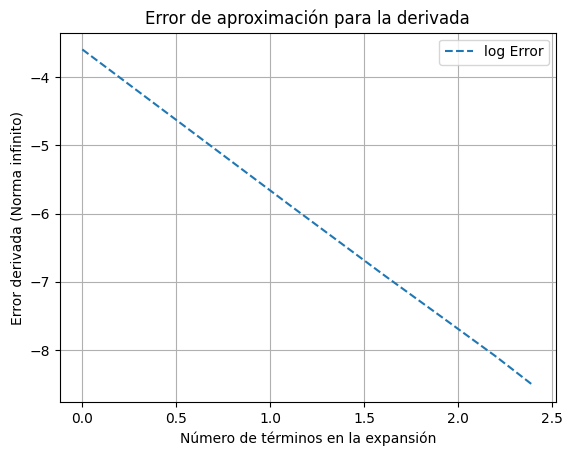

In [208]:
reps = 6
error_max_u_ms = np.zeros(reps)
error_max_du_ms = np.zeros(reps)
terms = np.zeros(reps)
for i in range(reps):
  n = 1 + 2*i
  error_rep_u = np.zeros(100) # Arreglo que almacena el error solo en esta repetición
  error_rep_du = np.zeros(100) # Arreglo que almacena el error para la derivada.
  x = np.linspace(0,1,100)
  sol_analitycal_e = u_analitycal(x) # Almacena la solución analítica solo en los puntos donde se calcula la numérica.
  du_a_e = du_analitycal(x) # Almacena la derivada analítica solo en los puntos donde se calcula la numérica.
  sol_ms, du_ms = minimum_squares(n, x) # Almacena la solución de Petrov Galerkin y su derivada.
  error_rep_u[1:] = np.abs((sol_analitycal_e[1:] - sol_ms[1:])/(sol_analitycal_e[1:]))
  error_max_u_ms[i] = np.max(error_rep_u)
  error_rep_du[1:] = np.abs((du_a_e[1:]-du_ms[1:])/(du_a_e[1:]))
  error_max_du_ms[i] = np.max(error_rep_du)
  terms[i] = n

fig, ax = plt.subplots()
ax.plot(np.log(terms), np.log(error_max_u_ms), label ='log Error', linestyle="--")
ax.set_xlabel('Número de términos en la expansión')
ax.set_ylabel('Error (Norma infinito)')
ax.set_title('Error solución MS')
plt.grid(True)
ax.legend()

fig, ax2 = plt.subplots()
ax2.plot(np.log(terms), np.log(error_max_du_ms), label ='log Error', linestyle="--")
ax2.set_xlabel('Número de términos en la expansión')
ax2.set_ylabel('Error derivada (Norma infinito)')
ax2.set_title('Error de aproximación para la derivada')
plt.grid(True)
ax2.legend()

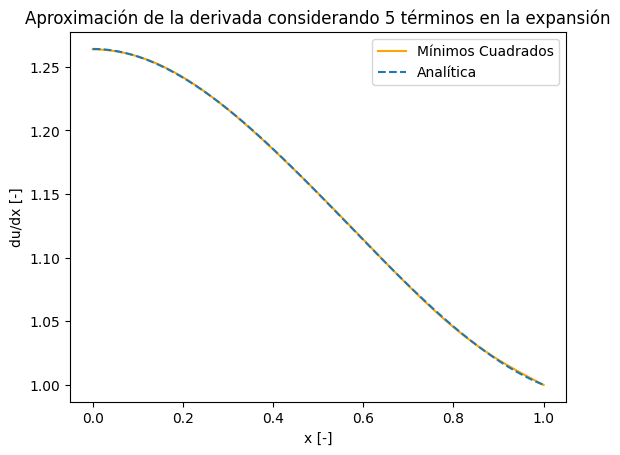

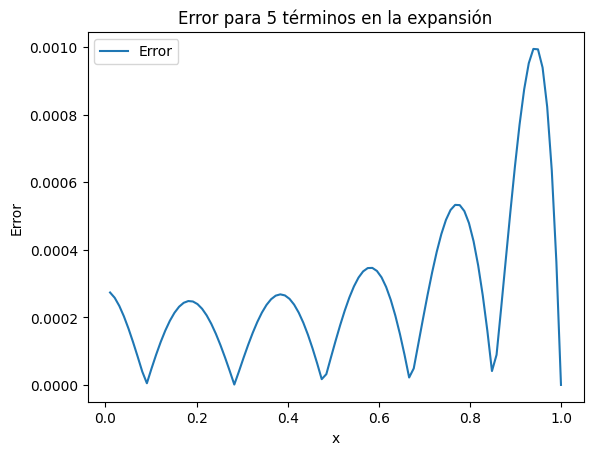

In [154]:
n = 5
x = np.linspace(0,1,100)
error = np.zeros(100)
du_a_e = du_analitycal(x)
_,du_ms = minimum_squares(n, x)
error[1:] = np.abs((du_a_e[1:] - du_ms[1:])/(du_a_e[1:]))

fig, ax = plt.subplots()
ax.plot(x, du_ms, label ='Mínimos Cuadrados', linestyle="-",color="orange")
ax.plot(x_a, du_a, label ='Analítica',linestyle='--')
ax.set_xlabel('x [-]')
ax.set_ylabel('du/dx [-]')
ax.set_title(f'Aproximación de la derivada considerando {n} términos en la expansión')
ax.legend()

fig_2, error_plot = plt.subplots()
error_plot.plot(x[1:], error[1:], label ='Error')
error_plot.set_xlabel('x')
error_plot.set_ylabel('Error')
error_plot.set_title(f'Error para {n} términos en la expansión')
error_plot.legend()

plt.show()

In [ ]:
def minimum_squares(n,x): ## Función antigua, usando solo senos
  K = np.zeros((n,n), dtype=float)
  M = np.zeros((n,n), dtype=float)
  F = np.zeros(n, dtype=float)
  u_j = np.zeros(len(x))
  du_j = np.zeros(len(x))
  for i in range(n):
    m_i = (i+0.5)*np.pi
    for j in range(n):
      m_j = (j+0.5)*np.pi
      K[i,j] = quad(K_ms, 0, 1, args=(i,j))[0]
      M[i,j] = quad(M_ms, 0, 1, args=(i,j))[0]
    F[i] = quad(external_forces_ms, 0, 1, args=(i))[0]
    F[i]+= -(-(m_i**2)*np.sin(m_i) + np.sin(m_i)) # (ddphi(1) + phi(1))*Q_L

  alpha = np.linalg.solve((K-M),F)

  for j in range(n):
    m_j = (j+0.5)*np.pi
    u_j+=alpha[j]*np.sin(m_j*x)
    du_j+= alpha[j]*m_j*np.cos(m_j*x)
  return u_j, du_j

def K_ms(x,i,j):
  # Función de Forma phi_j = sin(m_j x)

  m_i = (i+0.5)*np.pi
  m_j = (j+0.5)*np.pi

  phi_i = np.sin(m_i*x)
  phi_j = np.sin(m_j*x)

  ddphi_i = -(m_i**2)*np.sin(m_i*x)

  return phi_j*(ddphi_i+phi_i)

def M_ms(x,i,j):
  # Función de Forma phi_j = sin(m_j x)

  m_i = (i+0.5)*np.pi
  m_j = (j+0.5)*np.pi

  dphi_i = m_i * np.cos(m_i*x)
  dphi_j = m_j * np.cos(m_j*x)

  dddphi_i = -(m_i**3)*np.cos(m_i*x)

  return dphi_j*(dddphi_i + dphi_i)

def external_forces_ms(x,i):

  m_i = (i+0.5)*np.pi

  phi = np.sin(m_i*x)
  ddphi = -(m_i**2)*np.sin(m_i*x)

  return (x**2)*(ddphi + phi)

## Comparaciones

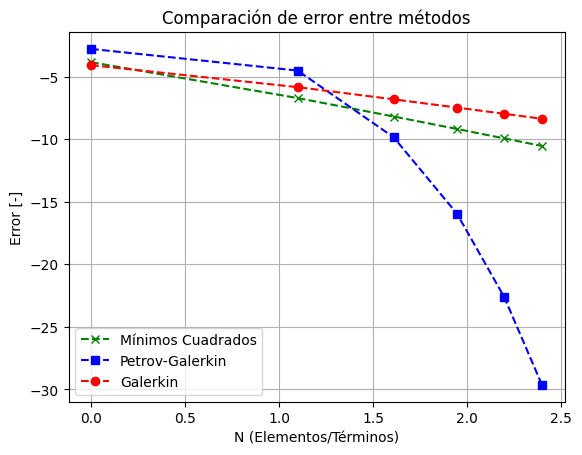

In [209]:
fig, ax = plt.subplots()
ax.plot(np.log(terms), np.log(error_max_u_ms), label ='Mínimos Cuadrados', linestyle="--",color="green", marker="x")
ax.plot(np.log(terms), np.log(error_max_u_pg), label ='Petrov-Galerkin',linestyle='--',color="blue", marker="s")
ax.plot(np.log(elements), np.log(error_max_u_g), label ='Galerkin',linestyle='--',color="red", marker="o")
ax.set_xlabel('N (Elementos/Términos)')
ax.set_ylabel('Error [-]')
ax.set_title('Comparación de error entre métodos')
ax.grid(True)
ax.legend()
plt.show()

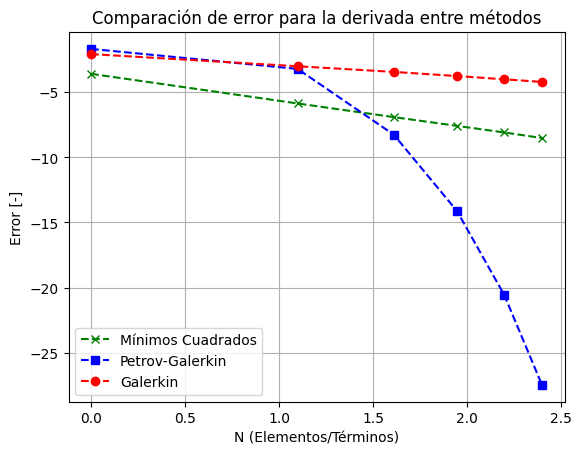

In [210]:
fig, ax = plt.subplots()
ax.plot(np.log(terms), np.log(error_max_du_ms), label ='Mínimos Cuadrados', linestyle="--",color="green", marker="x")
ax.plot(np.log(terms), np.log(error_max_du_pg), label ='Petrov-Galerkin',linestyle='--',color="blue", marker="s")
ax.plot(np.log(elements), np.log(error_max_du_g), label ='Galerkin',linestyle='--',color="red", marker="o")
ax.set_xlabel('N (Elementos/Términos)')
ax.set_ylabel('Error [-]')
ax.set_title('Comparación de error para la derivada entre métodos')
ax.grid(True)
ax.legend()
plt.show()